# Identify Alleles with Cell Count Differences

In [67]:
# Imports
import os
import warnings
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel
from plot_utils import *
import sys
sys.path.append("../../../..")
from utils import *

PLATEMAP_DIR = "../../../1_inputs/1_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
PROF_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/batch_profiles/"
CLASS_RES_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_results"

In [2]:
BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"

IMG_QC_DIR = f"../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/1.image_qc_outputs/{COMBINED_BIO_REP_DIR}"
OUTPUT_DIR = f"../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/2.cell_count_abundance_change/{COMBINED_BIO_REP_DIR}"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## 1. Summarize Cell Count Profiles

### 1.1 Allele Metadata

In [3]:
batch_id = BIO_REP_BATCHES[0]
allele_meta_df = pl.DataFrame()
for platemap in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)):
    platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
    allele_meta_df = pl.concat([allele_meta_df, platemap_df], how="diagonal_relaxed")
allele_meta_df

plate_map_name,well_position,symbol,gene_allele,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter
str,str,str,str,str,str,str,str,f64,str,str,str,f64,f64,f64,f64,str,str,str,str,f64,str,i64,i64,i64,i64,i64,i64,str
"""B13A7A8P1_R1""","""A01""","""ABCD1""","""ABCD1""","""A01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""disease_wt""",1.00008637e8,null,null,null,7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,1,1,1,"""A"""
"""B13A7A8P1_R1""","""C01""","""ABCD1""","""ABCD1_Arg518Trp""","""C01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007022""","""1552C>T""","""Arg518Trp""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,2,3,1,"""C"""
"""B13A7A8P1_R1""","""E01""","""ABCD1""","""ABCD1_Arg389Gly""","""E01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007023""","""1165C>G""","""Arg389Gly""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,3,5,1,"""E"""
"""B13A7A8P1_R1""","""G01""","""ABCD1""","""ABCD1_Arg518Gln""","""G01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007021""","""1553G>A""","""Arg518Gln""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,4,7,1,"""G"""
"""B13A7A8P1_R1""","""I01""","""BAP1""","""BAP1""","""I01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""disease_wt""",3760.0,null,null,null,7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,5,9,1,"""I"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""B13A7A8P2_R1""","""L12""",null,null,"""L12""","""B13A7A8P2_R1""","""B14A7A8P2_R2""",null,null,null,null,null,7.0,2.0,13.0,14.0,null,null,null,null,null,null,2,4,6,6,12,12,"""L"""
"""B13A7A8P2_R1""","""L14""","""MAPK9""","""MAPK9""","""L14""","""B13A7A8P2_R1""","""B14A7A8P2_R2""","""NC""",null,null,null,null,7.0,2.0,13.0,14.0,null,null,null,null,527.0,null,2,4,7,6,12,14,"""L"""
"""B13A7A8P2_R1""","""J16""","""RHEB""","""RHEB""","""J16""","""B13A7A8P2_R1""","""B14A7A8P2_R2""","""NC""",null,null,null,null,7.0,2.0,13.0,14.0,null,null,null,null,527.0,null,2,4,8,5,10,16,"""J"""


In [4]:
allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])
tested_variants = allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])["gene_allele"]

In [5]:
clin_var_annot_df = pl.read_csv("../../../../../1_allele_collection/3_outputs/varchamp_clinvar_gnomad.tsv", separator="\t", infer_schema_length=10000)
allele_meta_df = allele_meta_df.join(
    clin_var_annot_df.with_columns(
        pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_allele")
    ),
    on="gene_allele",
    how="left"
)
allele_meta_df

plate_map_name,well_position,symbol,gene_allele,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter,symbol_right,ensembl_gene_id,orf_id_wt_right,mutation_id_old,ccsb_mutation_id_right,ccsb_allele_id,spdi,nt_change,…,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,clinvar_nt_change,clinvar_aa_change,RefSeq_mRNA,StarStatus,clinvar_clnsig_clean,chr,chr_pos_38,ref_right,alt_right,gnomad_af
str,str,str,str,str,str,str,str,f64,str,str,str,f64,f64,f64,f64,str,str,str,str,f64,str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,str,str,str,…,str,str,str,str,str,i64,i64,str,str,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str
"""B13A7A8P1_R1""","""A01""","""ABCD1""","""ABCD1""","""A01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""disease_wt""",1.00008637e8,null,null,null,7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,1,1,1,"""A""",null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""B13A7A8P1_R1""","""C01""","""ABCD1""","""ABCD1_Arg518Trp""","""C01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007022""","""1552C>T""","""Arg518Trp""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,2,3,1,"""C""","""ABCD1""","""ENSG00000101986""",100008637,209133,"""CCSBVarC007022""","""ALE00007020""","""NC_000023.11:153740155:C:T""","""1552C>T""",…,"""germline;unknown""","""germline""","""GRCh38""","""NC_000023.11""","""X""",153740155,153740155,"""Xq28""","""criteria provided, multiple su…",9,"""-""","""N""","""ClinGen:CA278115,UniProtKB:P33…",3,11307,153740155,"""C""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000109783|SCV000918373|SCV0…","""-""","""-""","""1552C>T ""","""Arg518Trp""","""NM_000033.4""",2,"""1_Pathogenic""",null,null,null,null,null
"""B13A7A8P1_R1""","""C01""","""ABCD1""","""ABCD1_Arg518Trp""","""C01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007022""","""1552C>T""","""Arg518Trp""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,2,3,1,"""C""","""ABCD1""",null,100008637,null,"""CCSBVarC007022""",null,"""NC_000023.11:153740155:C:T""",null,…,"""germline;unknown""","""germline""","""GRCh38""","""NC_000023.11""","""X""",153740155,153740155,"""Xq28""","""criteria provided, multiple su…",9,"""-""","""N""","""ClinGen:CA278115,UniProtKB:P33…",3,11307,153740155,"""C""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000109783|SCV000918373|SCV0…","""-""","""-""","""1552C>T ""","""Arg518Trp""","""NM_000033.4""",2,"""1_Pathogenic""",null,null,null,null,null
"""B13A7A8P1_R1""","""E01""","""ABCD1""","""ABCD1_Arg389Gly""","""E01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007023""","""1165C>G""","""Arg389Gly""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,3,5,1,"""E""","""ABCD1""","""ENSG00000101986""",100008637,209127,"""CCSBVarC007023""","""ALE00007021""","""NC_000023.11:153736195:C:G""","""1165C>G""",…,"""germline""","""germline""","""GRCh38""","""NC_000023.11""","""X""",153736195,153736195,"""Xq28""","""criteria provided, multiple su…",3,"""-""","""N""","""ClinGen:CA278102,UniProtKB:P33…",3,11296,1537361

### 1.2 Cell Count Profiles

In [6]:
combined_profiles = pl.DataFrame()
for batch_id in BIO_REP_BATCHES:
    # Get meta features
    batch_alleles = (
        pl.scan_parquet(
            f"{PROF_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
        )
        .select([
            "Metadata_gene_allele",
            "Metadata_Well",
            "Metadata_Plate",
        ])
    )
    combined_profiles = pl.concat([combined_profiles, batch_alleles.collect()])

## Get the cell count per allele in each well
well_profiles = combined_profiles.group_by([
    "Metadata_Well", "Metadata_Plate", "Metadata_gene_allele"
]).len().rename({"len": "Cell_count"})
print(well_profiles.filter(pl.col("Metadata_gene_allele").str.contains("_")).unique(subset="Metadata_gene_allele"))

img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR}/plate-well-level_img_qc_sum.csv")
img_well_qc_sum_dapi = img_well_qc_sum.filter(pl.col("channel")=="DAPI").with_columns(
    pl.col("plate").alias("Metadata_Plate"),
    pl.col("well").alias("Metadata_Well"),
)
well_profiles = well_profiles.join(
    img_well_qc_sum_dapi,
    on=["Metadata_Plate","Metadata_Well"],
    how="left"
)

print("Original image wells:", well_profiles.shape[0])

shape: (591, 4)
┌───────────────┬─────────────────────────┬──────────────────────┬────────────┐
│ Metadata_Well ┆ Metadata_Plate          ┆ Metadata_gene_allele ┆ Cell_count │
│ ---           ┆ ---                     ┆ ---                  ┆ ---        │
│ str           ┆ str                     ┆ str                  ┆ u32        │
╞═══════════════╪═════════════════════════╪══════════════════════╪════════════╡
│ H04           ┆ 2025_01_28_B14A7A8P2_T1 ┆ CCM2_Arg423Cys       ┆ 348        │
│ L07           ┆ 2025_01_27_B13A7A8P2_T3 ┆ CCM2_Ser202Arg       ┆ 487        │
│ H06           ┆ 2025_01_28_B14A7A8P2_T4 ┆ CCM2_Ile432Phe       ┆ 306        │
│ A21           ┆ 2025_01_28_B14A7A8P1_T2 ┆ BRCA1_Ala102Gly      ┆ 253        │
│ L15           ┆ 2025_01_27_B13A7A8P1_T1 ┆ KRAS_Gly12Val        ┆ 159        │
│ …             ┆ …                       ┆ …                    ┆ …          │
│ O07           ┆ 2025_01_27_B13A7A8P2_T1 ┆ G6PD_Arg246Leu       ┆ 492        │
│ I04           ┆ 2025_0

In [7]:
# def plot_cc_per_plate(well_profile_df):
#     plate_maps = set(["_".join(plate_map.split("_")[:-1]) for plate_map in sorted(well_profile_df["Metadata_Plate"].unique())])
#     for plate_map in plate_maps:
#         plate_map_cc = well_profile_df.filter(pl.col("Metadata_Plate").str.contains(plate_map))
#         plates = sorted(plate_map_cc["Metadata_Plate"].unique().to_list())
#         fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
#         for plate in plates:
#             plate_info = plate_map_cc.filter(pl.col("Metadata_Plate")==plate)
#             # display(plate_info.filter(pl.col("is_bg")))
#             # print(plates.index(plate))
#             plot_platemap(
#                 plate_info,
#                 plate,
#                 well_pos_col="Metadata_Well",
#                 # this is the column to color by (categorical or continuous)
#                 value_col="Cell_count",
#                 # these columns will be concatenated into the annotation text
#                 label_cols=("Metadata_gene_allele","Cell_count"),
#                 ax=axes[plates.index(plate)//2, plates.index(plate)%2],
#                 value_type="continuous",   # or "continuous"
#                 continuous_cmap="vlag",  # matplotlib colormap for continuous mode
#                 grid_square=None
#             )
#         fig.subplots_adjust(wspace=-.55, hspace=.05)
#         plt.tight_layout()
#         plt.show()
#         break
# plot_cc_per_plate(well_profiles)

In [8]:
well_profiles = well_profiles.filter(~pl.col("is_bg"))
print("Image wells after QC based on DAPI:", well_profiles.shape[0])

Image wells after QC based on DAPI: 5322


In [9]:
batch_log_files = [
    f"{CLASS_RES_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/classify.log" \
    for batch_id in BIO_REP_BATCHES
]

dropped_well_df = pl.DataFrame()
for logfile in batch_log_files:
    with open(logfile, encoding="latin-1") as f:
        lines = f.readlines()
    dropped_wells = [(l.split(",")[0].strip(), l.split(",")[1].strip()) for l in lines if l.startswith("2025")]
    dropped_well_df = pl.concat([dropped_well_df, 
                                 pl.DataFrame({"plate": [well[0] for well in dropped_wells],
                                               "imaging_well": [well[1].split(":")[0] for well in dropped_wells],
                                               "gene_allele": [well[1].split(":")[1] for well in dropped_wells]})])
# dropped_well_df.filter(pl.col("gene_allele").is_in(img_well_qc_sum_dapi.filter(pl.col("is_bg"))["gene_allele"].unique()))

## 2. Cell Count Change Detection

### 2.1 Paired T-test

In [35]:
from scipy.stats import shapiro
import re
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import pandas as pd


# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge
    

def paired_ttest(dat, reference: str, var: str):
    ## perform stat test
    ## sorted the two alleles to make sure they are from the same plate for paired t-test    
    # if (dat[dat["Metadata_gene_allele"]==reference].shape[0] != dat[dat["Metadata_gene_allele"]==var].shape[0]):
    # pivot to wide: one row per plate
    wide_cc = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values="Cell_count")
    
    # drop any plate that doesn’t have both measurements
    wide_cc = wide_cc.dropna(subset=[reference, var])
    
    if wide_cc.shape[0] >= 3:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_cc[reference].astype(int), wide_cc[var].astype(int))
    else:
        t_stat, p_val = None, None

    # df_sampled["PlateID"] = df_sampled["Metadata_Plate"].str.extract(r"(P\d+T\d+)", expand=False)
    ## adjust for edge effect
    # dat["dist2edge"] = dat["Metadata_Well"].apply(lambda x: compute_distance(well_to_coordinates(x)[1], well_to_coordinates(x)[2]))
    # fit Cell_count ~ dist2edge
    # m0 = smf.ols("Cell_count ~ dist2edge", data=dat).fit()
    # dat["resid"] = m0.resid
    # ## calc t-test on residuals corrected for distance to edge
    # wide_res = dat.pivot(index="Metadata_Plate",
    #                     columns="Metadata_gene_allele",
    #                     values="resid")
    # # drop any plate that doesn’t have both measurements
    # wide_res = wide_res.dropna(subset=[reference, var])
    # if wide_res.shape[0] >= 3:
    #     # now run paired t-test
    #     res_t_stat, res_p_val = ttest_rel(wide_res[reference], wide_res[var])
    # else:
    #     res_t_stat, res_p_val = None, None

    # if t_stat > 15 or t_stat < -15:
    #     print(ttest_rel(wide_cc[reference].values, wide_cc[var].values))
    #     print(wide_cc)
    #     print(wide_cc[reference].values, wide_cc[var].values)
    #     print(t_stat, p_val)
        
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            # "t_stat_res": res_t_stat,
            # "p_val_res": res_p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df

In [52]:
well_cc_stats = []

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele or allele not in tested_variants:
        continue

    reference = allele.split("_")[0]
    temp_prof = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    ).select(
        pl.col(["Metadata_gene_allele","Metadata_Plate","Metadata_Well","Cell_count"])
    ).to_pandas()

    if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
        # print(temp_prof)
        continue

    var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
    ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Plate"].isin(var_profiles["Metadata_Plate"].unique()))]
    temp_prof = pd.concat([var_profiles, ref_profiles])

    ## Select ONLY the wells most distant from the edge per each allele to minimize the well-position edge effects
    ## deprecated: let's compare every pair
    # if (ref_profiles.shape[0] > var_profiles.shape[0]):
    #     ref_al_wells = ref_profiles["Metadata_Well"].unique()
    #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
    #     # Sort wells by max distance from edges (descending)
    #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
    #     ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
    # if (ref_profiles.shape[0] < var_profiles.shape[0]):
    #     ref_al_wells = var_profiles["Metadata_Well"].unique()
    #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
    #     # Sort wells by max distance from edges (descending)
    #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
    #     var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

    ref_wells = ref_profiles["Metadata_Well"].unique()
    var_wells = var_profiles["Metadata_Well"].unique()
    ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
    # print(ref_var_pairs)
    
    ## Per each ref-var well pair on the SAME plate, use paired-t-test to detect differences in CC
    for ref_var in ref_var_pairs:
        ## sort the wells to make sure they are from the same plate
        df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
        paired_t_res = paired_ttest(
            dat=df_sampled,
            reference=reference,
            var=allele
        ).with_columns(
            pl.lit(ref_var[0]).alias("Ref_well"),
            pl.lit(ref_var[1]).alias("Var_well")
        )
        # if paired_t_res["t_stat"].to_numpy()[0] > 15 or paired_t_res["t_stat"].to_numpy()[0] < -15:
        #     display(df_sampled)
        #     break
        well_cc_stats.append(
            paired_t_res
        )
        
well_cc_stats = pl.concat(well_cc_stats,  how="vertical")
well_cc_stats = well_cc_stats.rename({"t_stat": "U2OS_paired_t_stat", "p_val": "U2OS_paired_t_pval"}) ## "t_stat_res": "U2OS_paired_tstat_edgedist_resid", "p_val_res": "U2OS_t_edgedist_resid_pval"
well_cc_stats = well_cc_stats.select(["Gene", "Variant", "U2OS_paired_t_stat", "U2OS_paired_t_pval", "Ref_well", "Var_well"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",
display(well_cc_stats)

100%|██████████| 618/618 [00:04<00:00, 139.07it/s]


Gene,Variant,U2OS_paired_t_stat,U2OS_paired_t_pval,Ref_well,Var_well
str,str,f64,f64,str,str
"""BAP1""","""BAP1_Arg718Gln""",0.945816,0.375738,"""I01""","""E03"""
"""BAP1""","""BAP1_Cys91Gly""",-1.51641,0.173198,"""I01""","""A03"""
"""RAD51D""","""RAD51D_Val66Leu""",-3.332291,0.012552,"""F24""","""P24"""
"""KRAS""","""KRAS_Lys5Asn""",-0.085843,0.933995,"""B13""","""J13"""
"""ZC4H2""","""ZC4H2_Val63Leu""",3.165618,0.015804,"""I06""","""M06"""
…,…,…,…,…,…
"""CCM2""","""CCM2_Phe217Leu""",null,null,"""B01""","""N09"""
"""CCM2""","""CCM2_Phe217Leu""",null,null,"""B02""","""N09"""
"""F9""","""F9_Phe395Ile""",2.751249,0.028453,"""G06""","""K08"""


In [53]:
display(well_cc_stats.sort(by="U2OS_paired_t_stat", descending=False))

Gene,Variant,U2OS_paired_t_stat,U2OS_paired_t_pval,Ref_well,Var_well
str,str,f64,f64,str,str
"""SHOC2""","""SHOC2_Thr494Asn""",null,null,"""K02""","""L21"""
"""SHOC2""","""SHOC2_Thr494Asn""",null,null,"""B23""","""A04"""
"""LMNA""","""LMNA_Arg335Trp""",null,null,"""O05""","""P23"""
"""SHOC2""","""SHOC2_Thr126Ile""",null,null,"""K02""","""B21"""
"""SHOC2""","""SHOC2_Thr126Ile""",null,null,"""B23""","""G04"""
…,…,…,…,…,…
"""F9""","""F9_Cys178Phe""",11.216382,0.001519,"""G06""","""A16"""
"""RHO""","""RHO_Arg135Leu""",12.70294,0.000015,"""I17""","""O17"""
"""CCM2""","""CCM2_Glu128Ala""",14.656285,0.000689,"""M10""","""G24"""


In [54]:
# Correct p-values???
# from statsmodels.stats.multitest import multipletests

## 3. Summarize Results

In [58]:
## drop the null alleles
well_cc_stats = well_cc_stats.drop_nulls(subset="U2OS_paired_t_stat")

## extract the alleles with only single appearance
variants_single = well_cc_stats.group_by("Variant").len().filter(pl.col("len")==1)["Variant"]
well_cc_stats_single = well_cc_stats.filter(pl.col("Variant").is_in(variants_single))

## extract the alleles with replicates
variants_replicate = well_cc_stats.group_by("Variant").len().filter(pl.col("len")>1).unique(subset="Variant")["Variant"]
well_cc_stats_rep = well_cc_stats.filter(pl.col("Variant").is_in(variants_replicate))

## check the consistency between replicates
well_cc_stats_rep_group = well_cc_stats_rep.group_by("Variant").agg(
    pl.len().alias("count"),
    (pl.col("U2OS_paired_t_stat")>0).sum().alias("desc"),
    (pl.col("U2OS_paired_t_stat")<0).sum().alias("incr")
)
print("Inconsistent CC change across replicates:", well_cc_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr"))))
inconsistent_alleles = well_cc_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr")))["Variant"].unique()
display(well_cc_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr"))))

## No problem them merge by mean
well_cc_stats_rep = well_cc_stats_rep.group_by(["Gene","Variant"]).agg(
    pl.col("U2OS_paired_t_stat").mean().alias("U2OS_paired_t_stat"),
    pl.col("U2OS_paired_t_pval").mean().alias("U2OS_paired_t_pval")
).with_columns(## set the inconsistent alleles to have pval=1
    pl.when(pl.col("Variant").is_in(inconsistent_alleles))
    .then(pl.lit(1))
    .otherwise(pl.col("U2OS_paired_t_pval"))
    .alias("manual_adj_pval")
)

Inconsistent CC change across replicates: shape: (179, 4)
┌────────────────┬───────┬──────┬──────┐
│ Variant        ┆ count ┆ desc ┆ incr │
│ ---            ┆ ---   ┆ ---  ┆ ---  │
│ str            ┆ u32   ┆ u32  ┆ u32  │
╞════════════════╪═══════╪══════╪══════╡
│ CCM2_Ala179Ser ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Ile130Val ┆ 3     ┆ 2    ┆ 1    │
│ CCM2_Glu366Lys ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Asn94Ser  ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Glu433Lys ┆ 3     ┆ 2    ┆ 1    │
│ …              ┆ …     ┆ …    ┆ …    │
│ CCM2_His247Asp ┆ 3     ┆ 2    ┆ 1    │
│ RAF1_Pro225Ser ┆ 3     ┆ 2    ┆ 1    │
│ CCM2_Cys211Ser ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Gln313Arg ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Ser398Tyr ┆ 3     ┆ 1    ┆ 2    │
└────────────────┴───────┴──────┴──────┘


Variant,count,desc,incr
str,u32,u32,u32
"""CCM2_Ala179Ser""",3,1,2
"""CCM2_Ile130Val""",3,2,1
"""CCM2_Glu366Lys""",3,1,2
"""CCM2_Asn94Ser""",3,1,2
"""CCM2_Glu433Lys""",3,2,1
…,…,…,…
"""CCM2_His247Asp""",3,2,1
"""RAF1_Pro225Ser""",3,2,1
"""CCM2_Cys211Ser""",3,1,2


In [59]:
well_cc_stats_final = pl.concat([
    well_cc_stats_rep,
    well_cc_stats_single.with_columns(
        pl.col("U2OS_paired_t_pval").alias("manual_adj_pval")
    ).select(pl.col(well_cc_stats_rep.columns))
])

well_cc_stats_final = well_cc_stats_final.with_columns(
    pl.col("manual_adj_pval").alias("U2OS_paired_t_pval")
)
well_cc_stats_final = well_cc_stats_final.select(["Gene", "Variant", "U2OS_paired_t_stat", "U2OS_paired_t_pval"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",

In [60]:
well_cc_stats_final

Gene,Variant,U2OS_paired_t_stat,U2OS_paired_t_pval
str,str,f64,f64
"""CCM2""","""CCM2_Ser164Phe""",-3.381957,0.240365
"""ZC4H2""","""ZC4H2_Val63Leu""",3.772509,0.00952
"""CCM2""","""CCM2_Asp442Asn""",-0.383562,1.0
"""SDHD""","""SDHD_Glu69Lys""",-7.23288,0.000174
"""CCM2""","""CCM2_Cys170Tyr""",-4.804395,1.0
…,…,…,…
"""RPS19""","""RPS19_Val15Phe""",2.372662,0.076599
"""BCL10""","""BCL10_Leu8Leu""",1.593538,0.186262
"""RAD51D""","""RAD51D_Glu233Gly""",-2.015139,0.083729


In [61]:
# Total number of increase vs. decrease
total = well_cc_stats_final.shape[0]

## We are comparing REF - VAR in the paired_ttest ttest_rel
## The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
## Thus, t-stat > 0 means REF more than VAR --> VAR decreasing CC
per_dec = well_cc_stats_final.filter(pl.col("U2OS_paired_t_stat") > 0).shape[0]
per_inc = well_cc_stats_final.filter(pl.col("U2OS_paired_t_stat") < 0).shape[0]

print("Total decreasin vs increasing percent:")
print(f"{per_dec}, {per_dec / total * 100:.2f} %")
print(f"{per_inc}, {per_inc / total * 100:.2f} %")

dec_sig = well_cc_stats_final.filter(pl.col("U2OS_paired_t_pval") < 0.05).filter(pl.col("U2OS_paired_t_stat") > 0).shape[0]
inc_sig = well_cc_stats_final.filter(pl.col("U2OS_paired_t_pval") < 0.05).filter(pl.col("U2OS_paired_t_stat") < 0).shape[0]

print("Number sig decreases")
print(f"{dec_sig}, {dec_sig / total * 100:.2f} %")
print("Number sig increases")
print(f"{inc_sig}, {inc_sig / total * 100:.2f} %")

Total decreasin vs increasing percent:
199, 42.16 %
273, 57.84 %
Number sig decreases
83, 17.58 %
Number sig increases
47, 9.96 %


In [62]:
well_cc_stats_final.write_csv(f"{OUTPUT_DIR}/well-level_cell-count_changes.csv")

## 4. Analyze wrt Clinvar Annotations

In [65]:
well_cc_stats_final_clinvar = well_cc_stats_final.join(
    allele_meta_df.select(pl.col(["gene_allele","clinvar_clnsig_clean"])), 
    left_on="Variant",
    right_on="gene_allele",
    how="inner"
).drop_nulls(subset="clinvar_clnsig_clean")

<Figure size 640x480 with 0 Axes>

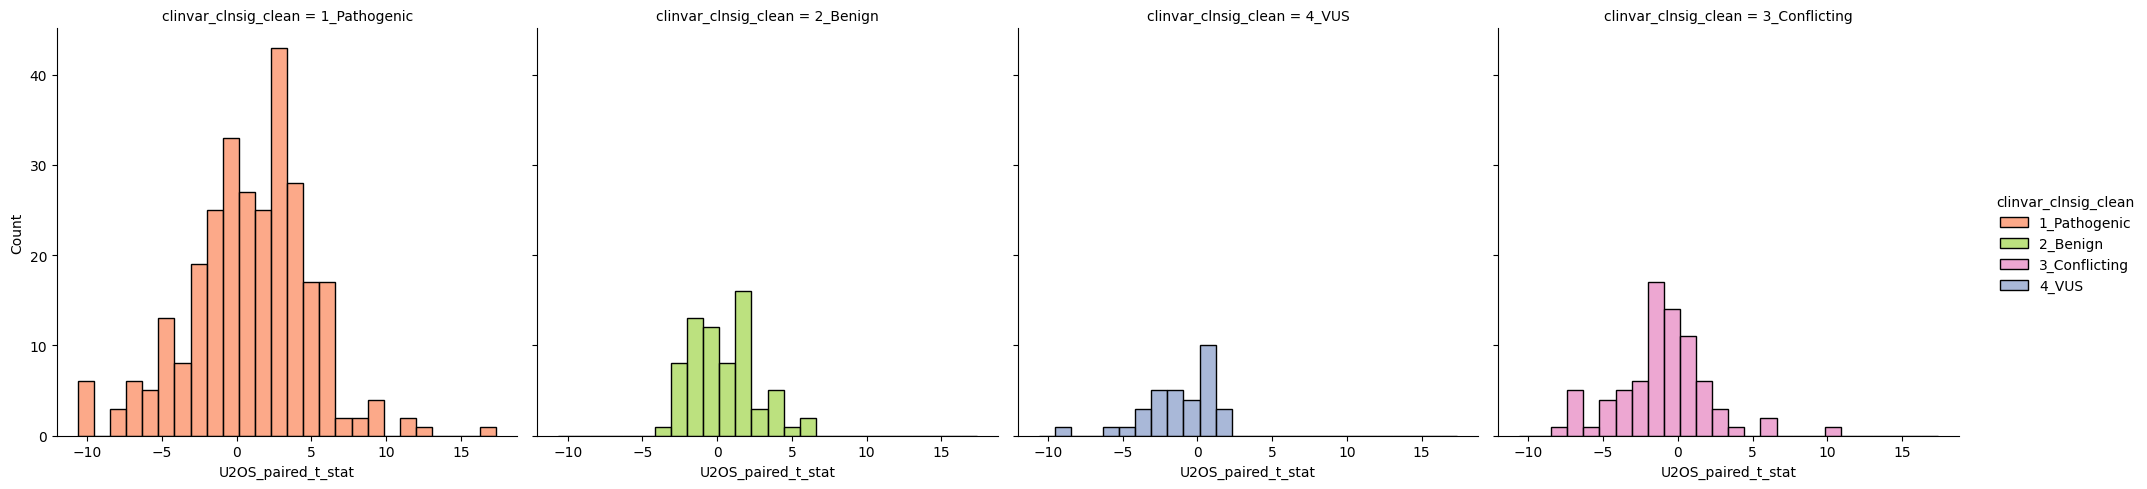

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf()
sns.displot(
    data=well_cc_stats_final_clinvar.filter(pl.col("clinvar_clnsig_clean")!="5_Others").to_pandas(),
    x="U2OS_paired_t_stat",
    col="clinvar_clnsig_clean",
    hue="clinvar_clnsig_clean",
    palette=palette_dict["clinvar_clnsig_clean"],
    hue_order=['1_Pathogenic', '2_Benign', '3_Conflicting', '4_VUS']
)
plt.show()